# 4998 Applied Deep Learning Project
## Detect Cancer Metastases on Pathology Images

Jing Qian (jq2282)

# STEP 1. IMAGE PROCESSING

* Read this paper to understand their approach https://arxiv.org/pdf/1703.02442.pdf
* Start small (use a single slide, at the lowest available zoom level - the effective resolution should be on the order of 1,000 by 1,000 pixels).
* Write code to slide a window across the slide. Extract patches and labels (using the tissue mask).

## 1.1. Import data

In [1]:
# Install the OpenSlide C library and Python bindings
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openslide-tools is already the newest version (3.4.1+dfsg-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# list all the slides provided by professor
!ls /content/drive/My Drive/slides

ls: cannot access '/content/drive/My': No such file or directory
ls: cannot access 'Drive/slides': No such file or directory


## 1.2. Start with one slide

In [0]:
total_path = '/content/drive/My Drive/slides/'

In [6]:
# see the sizes of files from one slide
!ls -hl /content/drive/My\ Drive/slides/tumor_091*

-r-------- 1 root root  15M Oct 10  2018 '/content/drive/My Drive/slides/tumor_091_mask.tif'
-r-------- 1 root root 522M Oct 10  2018 '/content/drive/My Drive/slides/tumor_091.tif'
-r-------- 1 root root  77K Oct 11  2018 '/content/drive/My Drive/slides/tumor_091.xml'


In [7]:
slide_path = os.path.join(total_path,'tumor_091.tif')
tumor_mask_path = os.path.join(total_path,'tumor_091_mask.tif')

slide = open_slide(slide_path)
print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
                                                        slide.level_dimensions[0][0], 
                                                        slide.level_dimensions[0][1]))

tumor_mask = open_slide(tumor_mask_path)
print ("Read tumor mask from %s" % (tumor_mask_path))

print("Slide includes %d levels", len(slide.level_dimensions))
for i in range(len(slide.level_dimensions)):
    print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                             slide.level_dimensions[i], 
                                                             slide.level_downsamples[i]))
    assert tumor_mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
    assert tumor_mask.level_dimensions[i][1] == slide.level_dimensions[i][1]

# Verify downsampling works as expected
width, height = slide.level_dimensions[7]
assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]

Read WSI from /content/drive/My Drive/slides/tumor_091.tif with width: 61440, height: 53760
Read tumor mask from /content/drive/My Drive/slides/tumor_091_mask.tif
Slide includes %d levels 8
Level 0, dimensions: (61440, 53760) downsample factor 1
Level 1, dimensions: (30720, 26880) downsample factor 2
Level 2, dimensions: (15360, 13440) downsample factor 4
Level 3, dimensions: (7680, 6720) downsample factor 8
Level 4, dimensions: (3840, 3360) downsample factor 16
Level 5, dimensions: (1920, 1680) downsample factor 32
Level 6, dimensions: (960, 840) downsample factor 64
Level 7, dimensions: (480, 420) downsample factor 128


In [0]:
# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0.
# There is an example below of working with coordinates
# with respect to a higher zoom level.

# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

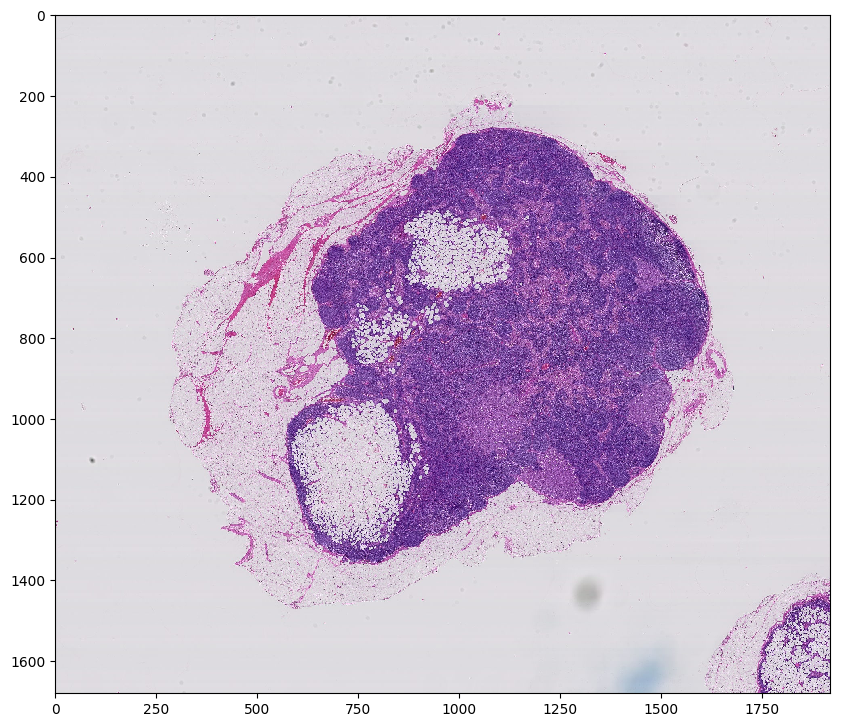

In [9]:
# Example: read the entire slide at level 5

# Higher zoom levels may not fit into memory.
# You can use the below function to extract regions from higher zoom levels 
# without having to read the entire image into ram.

# Use the sliding window approach discussed in class to collect training
# data for your classifier. E.g., slide a window across the slide (for
# starters, use a zoomed out view, so you're not working with giant images).
# Save each window to disk as an image. To find the label for that image, 
# check to the tissue mask to see if the same region contains cancerous cells.

# Important: this is tricky to get right. Carefully debug your pipeline before
# training your model. Start with just a single image, and a relatively 
# low zoom level.

slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=5, 
                         width=slide.level_dimensions[5][0], 
                         height=slide.level_dimensions[5][1])

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)

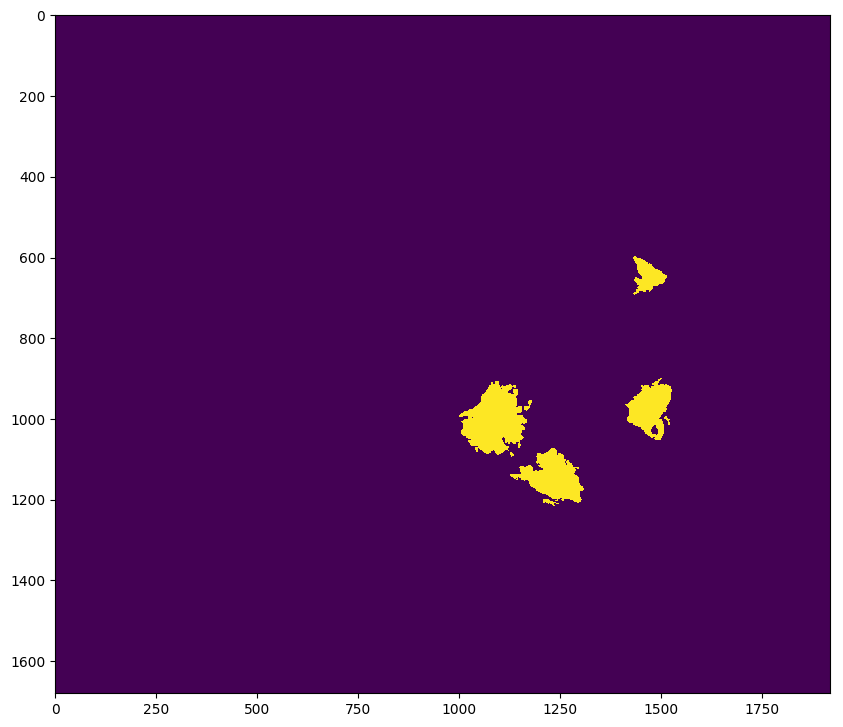

In [10]:
# Example: read the entire mask at the same zoom level
mask_image = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=5, 
                        width=slide.level_dimensions[5][0], 
                        height=slide.level_dimensions[5][1])

# Note: the program provided by the dataset authors generates a mask with R,G,B channels.
# The mask info we need is in the first channel only.
# If you skip this step, the mask will be displayed as all black.
mask_image = mask_image[:,:,0]

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(mask_image)

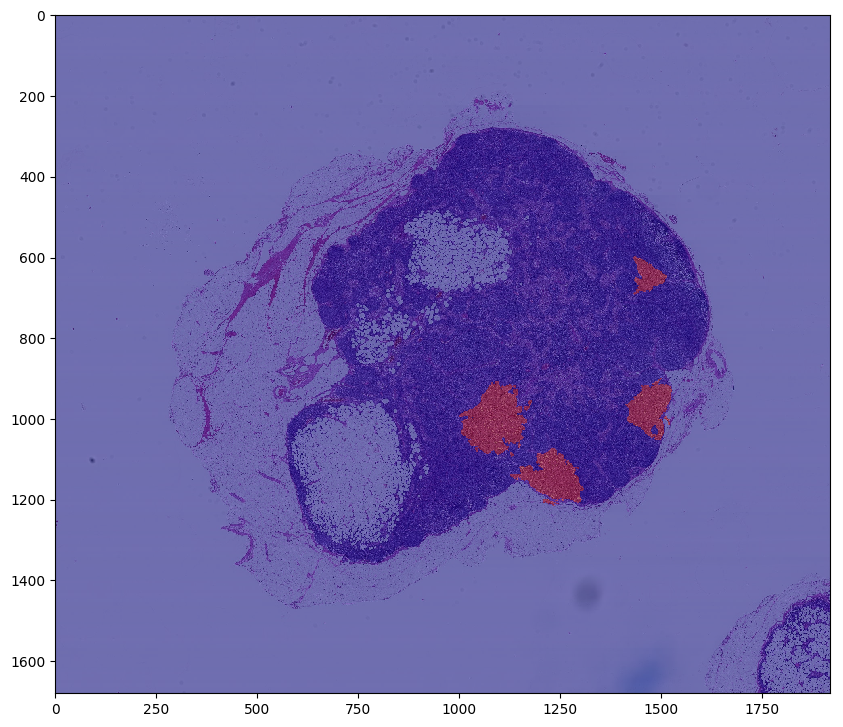

In [11]:
# Overlay them. The idea is that the mask shows the region of the slide that
# contain cancerous cells.
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(mask_image, cmap='jet', alpha=0.5) # Red regions contains cancer.

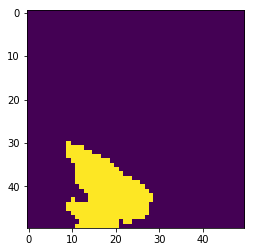

In [12]:
# Example: extract a region from the L7 downsampled image
# Notice we're multiplying the x,y coordinates by the downsample factor.
# This math can be tricky to get right, debug carefully.
# Here, we're "aiming" for the top right blob in the image above.
region = read_slide(tumor_mask, x=350 * 128, y=120 * 128, level=7, width=50, height=50)[:,:,0]
plt.imshow(region)

905504 tissue_pixels pixels (32.1 percent of the image)


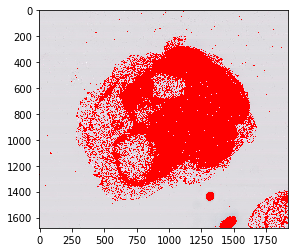

In [13]:
# As mentioned in class, we can improve efficiency by ignoring non-tissue areas 
# of the slide. We'll find these by looking for all gray regions.
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return zip(indices[0], indices[1])

tissue_pixels = list(find_tissue_pixels(slide_image))
percent_tissue = len(tissue_pixels) / float(slide_image.shape[0] * slide_image.shape[0]) * 100
print ("%d tissue_pixels pixels (%.1f percent of the image)" % (len(tissue_pixels), percent_tissue)) 

def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked

tissue_regions = apply_mask(slide_image, tissue_pixels)
plt.imshow(tissue_regions)

# STEP 2. MODELING

* Although transfer learning may be less effective than training a model from scratch , it is the best place to start.
* Choose a model previously trained on Imagenet. Use the techniques in Chapter 5 of Francois’s book to try transfer learning (add a single Dense layer on top of that model), and train it on your own data.
* Write a script that takes your trained model and a testing image, and outputs a heat map showing the cancerous regions.
* Design an evaluation metric, write a script to report your results

加快速度，不看背景，只看tissue。比如对色彩做个threshold

选一个特别放大的开始做，比如800\*600 pixel图片
annotation. 选择哪部分有cancer

image segmentation, 
